## Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pylab as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

In [2]:
pd.set_option('display.max_rows', 25000)
torch.set_printoptions(threshold=100_000)

## Preprocessing Data

In [3]:
path = './gludata/data'
with open(path+"/train_data_pyforecast.pkl", 'rb') as f:
      train_data_raw = pickle.load(f)
with open(path+"/val_data_pyforecast.pkl", 'rb') as f:
      val_data_raw = pickle.load(f)
with open(path+"/test_data_pyforecast.pkl", 'rb') as f:
      test_data_raw = pickle.load(f)

In [5]:
def read_data(data, id_start):
    data_len = sum([len(data[i][1]) for i in range(len(data))])
    data_pd = pd.DataFrame(index = range(data_len),
                           columns = ["timeidx", "id", "subject", "CGM", 
                                      "dayofyear", "dayofmonth", "dayofweek", "hour", 
                                      "minute", "date"])
    start = 0
    for i in range(len(data)):
        block_len = len(data[i][1]) 
        data_pd["timeidx"][start:(start+block_len)] = range(block_len)
        data_pd["id"][start:(start+block_len)] = [id_start + i] * block_len
        data_pd["subject"][start:(start+block_len)] = [data[i][0]] * block_len
        data_pd["CGM"][start:(start+block_len)] = data[i][1].flatten() 
        data_pd["date"][start:(start+block_len)] = data[i][3]
        start += block_len
    
    # set format
    data_pd["id"] = data_pd["id"].astype(str).astype("string").astype("category")
    data_pd["subject"] = data_pd["subject"].astype(str).astype("string").astype("category")
    data_pd["CGM"] = data_pd["CGM"].astype("float")
    data_pd["timeidx"] = data_pd["timeidx"].astype("int")
    
    #extract time features
    data_pd["date"] = pd.to_datetime(data_pd["date"])
    data_pd["dayofyear"] = data_pd["date"].dt.dayofyear.astype("string").astype("category")
    data_pd["dayofmonth"] = data_pd["date"].dt.day.astype("string").astype("category")
    data_pd["dayofweek"] = data_pd["date"].dt.dayofweek.astype("string").astype("category")
    data_pd["hour"] = data_pd["date"].dt.hour.astype("string").astype("category")
    data_pd["minute"] = data_pd["date"].dt.minute.astype("string").astype("category")
    
    # reset index
    data_pd = data_pd.reset_index()
    data_pd = data_pd.drop(columns=["index"])
    return data_pd

train_data_pd = read_data(train_data_raw, 0)
train_data_pd_subset = read_data(train_data_raw_subset, 0)
val_data_pd = read_data(val_data_raw, len(train_data_raw))
test_data_pd = read_data(test_data_raw, len(train_data_raw)+len(val_data_raw))

In [10]:
test_data = TimeSeriesDataSet(
    test_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["subject"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    scalers=[],
    add_relative_time_idx=True,
    add_encoder_length=True,
)
test_dataloader = test_data.to_dataloader(train=False, batch_size=64, num_workers=24)

## Evaluate

In [11]:
# best_model_path = trainer.checkpoint_callback.best_model_path
saved_model_path = './saved_models/tft_001.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(saved_model_path)

In [12]:
pred, x = best_tft.predict(test_dataloader, mode='raw', return_x=True)
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])

In [14]:
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2
BATCH_SIZE=1

pred = (pred['prediction'] + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
pred_median = pred[:, :, 3] 
actuals = (actuals + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER

In [15]:
# evaluate on full data set
def ape_rmse(actuals, predictions, length, event):
    HYPO_THR = 70
    HYPER_THR = 180

    if event == 'HYPO':
        select = (actuals <= HYPO_THR).any(axis=1)
    elif event == 'HYPER':
        select = (actuals <= HYPER_THR).any(axis=1)
    elif event == 'EVENT':
        select = ((actuals <= HYPO_THR).any(axis=1) |  (actuals >= HYPER_THR).any(axis=1))
    else:
        select = range(actuals.shape[0])
    actuals = actuals[select, :]
    predictions = predictions[select, :]
    ape = ((actuals[:, :length] - predictions[:, :length]).abs() / actuals[:, :length].abs()).mean(axis=1).median()
    rmse = ((actuals[:, :length] - predictions[:, :length]) ** 2).mean(axis=1).sqrt().median()
    return (ape, rmse)

lengths = [3, 6, 9 , 12]
events = ['HYPO', 'HYPER', 'EVENT', 'FULL']

for length in lengths:
    for event in events:
        print('Length: {0}, event: {1}, ape: {2}, rmse: {3}'.format(length, 
                                                                    event, 
                                                                    *ape_rmse(actuals, pred_median, length, event)))

Length: 3, event: HYPO, ape: 0.04788941144943237, rmse: 3.493262529373169
Length: 3, event: HYPER, ape: 0.03284105286002159, rmse: 4.548535346984863
Length: 3, event: EVENT, ape: 0.03067588061094284, rmse: 6.7185797691345215
Length: 3, event: FULL, ape: 0.03004472516477108, rmse: 5.445246696472168
Length: 6, event: HYPO, ape: 0.08740741014480591, rmse: 6.7011613845825195
Length: 6, event: HYPER, ape: 0.05418586730957031, rmse: 7.891816139221191
Length: 6, event: EVENT, ape: 0.04706926271319389, rmse: 10.835981369018555
Length: 6, event: FULL, ape: 0.04703297093510628, rmse: 9.001038551330566
Length: 9, event: HYPO, ape: 0.12386848032474518, rmse: 9.628799438476562
Length: 9, event: HYPER, ape: 0.0746939480304718, rmse: 10.901311874389648
Length: 9, event: EVENT, ape: 0.06265374273061752, rmse: 14.559313774108887
Length: 9, event: FULL, ape: 0.06274881958961487, rmse: 12.185905456542969
Length: 12, event: HYPO, ape: 0.15511898696422577, rmse: 12.3118896484375
Length: 12, event: HYPER, a

In [16]:
pred_one = np.vstack((pred[0, :, 0].numpy(),
          pred[0, :, 3].numpy(),
          pred[0, :, 6].numpy(),))

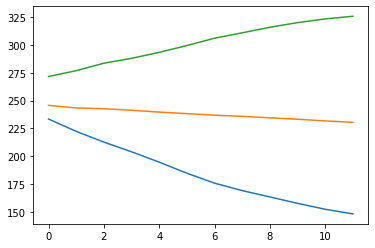

In [17]:
plt.plot(np.transpose(pred_one))